# Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [4]:
from src.data.location_notebook import get_location
import src.features.build_features as bf
import src.visualization.visualize as vz

In [5]:
(DATA_DIR, DATA_DIR_PROCESSED, 
INTERMEDIATE_RESULTS, GROUP_INTERMEDIATE_RESULTS, 
CLEANED_DS , TRAIN_RAW_FILE, 
VALIDATION_RAW_FILE, TEMPLATE_SUBMIT) = get_location()

In [6]:
date_columns = [
    "Account_Created_Date", 
    "Opportunity_Created_Date",
    "Last_Activity",
    "Quote_Expiry_Date",
    "Last_Modified_Date",
    "Planned_Delivery_Start_Date",
    "Planned_Delivery_End_Date",
    "Actual_Delivery_Date"
]

df_train = pd.read_csv(os.path.join(DATA_DIR, TRAIN_RAW_FILE), parse_dates=date_columns, na_values=["None"])
df_val = pd.read_csv(os.path.join(DATA_DIR, VALIDATION_RAW_FILE), parse_dates=date_columns, na_values=["None"])
template_submit = pd.read_csv(os.path.join(DATA_DIR, TEMPLATE_SUBMIT))

/home/jloscalzo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Resumen

### Objetivo

La variable que se está tratando de predecir es “Probabilidad de éxito” para cada oportunidad. 
¿Cuál es la probabilidad de que la oportunidad se convierta en un caso Closed Won?

### Identificación
Las filas se identifican con dos features: ID y Opportunity_ID.

ID identifica al registro y Opportunity_ID al "presupuesto" o "Oportunidad".

Si agrupamos por Opportunity_ID podemos tener en una sola fila, toda la información.
Pero hay que tener en cuenta que hay ciertas filas que se tienen que agregar (no todas)

- TRF
- total_amount y sus derivados
- Todos los one-hot de productos, familia productos
- derivadas de planned_delivery_date

### Limpieza

Observando el reporte vamos a descartar las siguientes columnas:

- "ID": identificador de registro, no sirve
- "Sales_Contract_No": 	41.1% de missings. 
    - terminará en una derivada. De todas formas esta feature no es correcta (data-leakage)
- "Opportunity_ID": este lo vamos a utilizar para identificar las rows, va a salir y entrar
- "Opportunity_Name": Lo quitamos, va de la mano con Opportunity_ID.
- "Account_Name": La uso para imputar Territorio y luego la remuevo.
<!-- - "Account_Owner", -->
- "Product Type": 94.0% missing
- "Last_Activity": 100% missing 
- "Quote_Type": muy desbalanceado, 99.0% en "non-binding"
- "Brand": 93.9% missing
- "Currency": 94.7% missing
- "Price": 94.3% missing
- "Submitted_for_Approval": constante
- "Actual_Delivery_Date": todas missings
- "Prod_Category_A": valor constante, asi que la quitamos
- "Stage": esta es el target, no es que la quitamos sino que lo agregamos como target

- has_contract
- imputamos ASP con valores promedios
- imputamos total amount y vemos que puede ser interesante aplicar robustScaler y  log1p


- Source se remueve
- Planned_Delivery_end_Date: se modifica un valor malo, año 2208, e imputamos con un valor de referencia
    - imputamos con 4 días + planned_delivery_start_date
    - realmente no sabemos si es error de datos, o puede ocurrir que solo den una fecha (dominio)
    - podríamos haber puesto 0 días (ya que la mayoría tiene 0)
- Quote_Expiry_date: mismo tratamiento que el de arriba, imputamos con un valor de referencia por medio de la fecha de creación.
- Territorio by Region: imputamos con valores correctos: 
    - japan va con japan, dubai con middle-east y americanos no pueden estar en apac.
- Billing_Country: a partir de esos territorios (con billing_country na), colocamos el más probable
- Territorio: creamos un modelo e imputamos. Luego eliminamos Account_Name
    - creamos una row casi sintética: tenia region y billing_country en na

### FE
- Planned_range_days
- Quote_rnage_days
- Modify_range_days
- Total_Amount_Converted y Total_Amount_Taxable_Converted
- Total_Amount_Opportunity y Total_Amount_Converted_Opportunity
- Diff_Amount
- Apply Log to numbers (?) 
- Opportunity_By_Owner
- Opportunity_history_By_Owner
- Dates treatment 
- Imputamos: Algunas faltantes más
    - Account_Type
- Product_stats
- One_Hot Product: Name & Family
- Aggregate y merge
    - una fila por opportunidad
- Acciones génericas para las otras columnas

______________________________

## Limpieza
### Columnas Iniciales

In [7]:
always_drop = [
    "ID", 
#     "Sales_Contract_No", # esta genera data-leakage
#     "Opportunity_ID", 
#     "Account_Name", # esta la uso para imputar Territorio , luego la remuevo
    "Opportunity_Name",
    "Quote_Type",
    "Brand",
    "Price",
    "Currency",
    "Product_Type",
    "Size",
    "Last_Activity",
    "Last_Modified_By",
#     "Last_Modified_Date",
#     "ASP",
#     "ASP_Currency",
#     "ASP_(converted)_Currency",
#     "ASP_(converted)",
    "Actual_Delivery_Date",
    "Product_Category_B",
    "Prod_Category_A",
    "Submitted_for_Approval",
    'Delivery_Year',
    'Month',
    'Delivery_Quarter'
#     "Stage"
]

creamos train y val. Unimos val para realizar las imputaciones. 


In [8]:
df_train = df_train.drop(
    columns=always_drop, 
#     errors='ignore'
)
df_train.loc[:,"train"] = 1

df_val = df_val.drop(
    columns=always_drop, 
    errors='ignore' # this is for stage
)

df_val.loc[:,"train"] = 0
df_val.loc[:,"Stage"] = "None"

In [9]:
# juntamos los dos datasets para ir haciendo la limpieza correspondiente
df_train = df_train.append(df_val, ignore_index=True)

In [10]:
# df_val.columns = df_train.columns.drop(["Stage"])
df_train.train.value_counts()

1    16947
0     2551
Name: train, dtype: int64

### Has_contract

- enviaron un correo avisando que esta variable tiene data-leakage
    - esto debe ocurrir porque alguien firma un contrato LUEGO de cerrar un negoci
    - puede ser que en el futuro, esos customers tengan más closed_wons y sean comparables. 

- Para la competencia, la dejamos pero ya sabemos que en un ambiente productivo estará mal


In [11]:
df_train = bf.add_has_contract(df_train)

/home/jloscalzo/Projects/py-ml/air_cond_AlixSadosky/aircond_alix_sadosky/src/features/build_features.py:11: UserWarning: Sales_Contract_No: data-leakage feature
  warnings.warn("Sales_Contract_No: data-leakage feature")


In [12]:
# con esto vemos por Stage, las que tienen o no contract
pd.crosstab(df_train.has_contract, df_train["Stage"],  margins = False)

Stage,Closed Lost,Closed Won,Negotiation,None,Proposal,Qualification
has_contract,,,,,,
0,6771,138,18,1213,35,11
1,579,9395,0,1338,0,0


### ASP
- [Qué es ASP - investopedia](https://www.investopedia.com/terms/a/averagesellingprice.asp)
- [Qué es ASP - wikipedia](https://en.wikipedia.org/wiki/Average_selling_price) 

- Sabemos que todas las monedas están en distintas unidades: EUR, USD, AUS, JPY...
- Total_Amount y Taxable_Total_Amount están en las mismas currecies.
- ASP y Total_Amount_Currency son las mismas, y 
    - ASP_(converted)_Currency son todos dolares, por ende vamos a pasar total_amount y taxable todo a dolares. 
- Lo que vamos a hacer es generar un rate promedio por periodo (YYYYMM) para imputar las que no tienen


La fórmula es la siguiente: 
```rate = 1 * asp / asp_converted```



In [13]:
(df_train.ASP_Currency == df_train.Total_Amount_Currency).all()

True

In [14]:
df_train, asp_imputer = bf.impute_rate(df_train)

In [15]:
# df_val.rate.isna().sum()
df_train.loc[df_train.rate.isna(), ["Opportunity_ID", "train"]]

,Opportunity_ID,train


In [16]:
df_train.train.value_counts()

1    16947
0     2551
Name: train, dtype: int64

### Stages
Filtramos solamente las que están dentro de esas dos categorías, ya que las otras aún no sabemos si van a ser cerradas.
Las otras se encuentra en un estado intermedio

In [17]:
# df_train = bf.filter_stages(df_train)

Verificamos columnas con vacíos

In [18]:
df_train.columns[df_train.isna().any()]

Index(['Territory', 'Source ', 'Billing_Country', 'Account_Type',
       'Quote_Expiry_Date', 'Planned_Delivery_End_Date', 'Total_Amount'],
      dtype='object')


### Total Amount

In [19]:
# verificamos las que tienen Total_Amount en NaN
mask = (df_train.Total_Amount.isna()) | (df_train.Total_Amount==0) 
df_train[mask].groupby(['Stage', 'train']).size()

Stage        train
Closed Lost  1        105
Closed Won   1          6
dtype: int64

Buscando que valores de Total_Amount se pueden imputar
- opción 1) podemos borrar todos los que tienen Total_Amount en Na o 0
- opción 2) buscamos para el currency y product, los valores promedios e imputamos los faltantes. 
- opción 3) buscamos para el currency, product y fecha de oportunidad. Imputamos por cercanía.

Vamos en orden inverso: 3, 2, 1. 

In [20]:
df_train.shape

(19498, 34)

In [21]:
df_train = bf.impute_total_amount(df_train)

/home/jloscalzo/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [22]:
df_train.Total_Amount_Imputed.value_counts(), df_train.Total_Amount.notna().all()

(-1    19439
  1       59
 Name: Total_Amount_Imputed, dtype: int64,
 True)

Verificamos como se comporta total_amount por stage, antes y luego de escalar (RobustScaler + log1p)

In [23]:
d = df_train[(df_train.Stage.isin(["Closed Won", "Closed Lost"])) & (df_train.train==1)].copy()

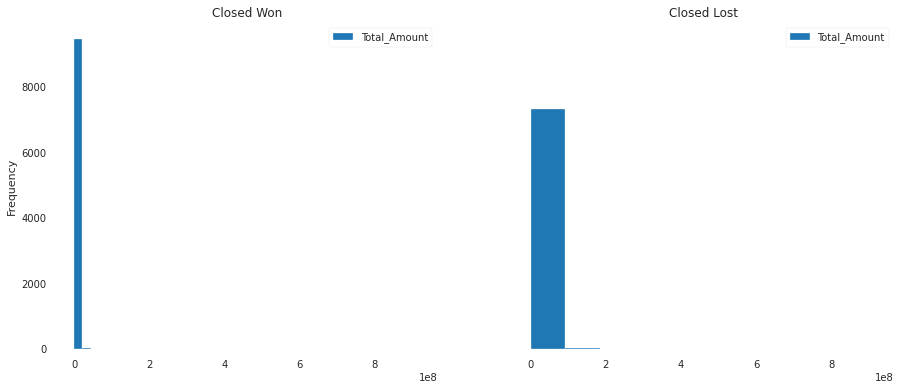

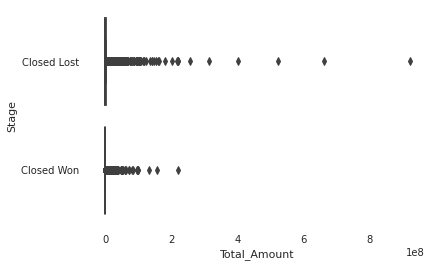

In [24]:
vz.plot_summary_total_amount(d)

In [25]:
# hacemos robustScaler y log1p.
mms =RobustScaler().fit_transform( np.log1p(d["Total_Amount"].values.reshape(-1,1)))

In [26]:
d["Total_Amount"] = mms

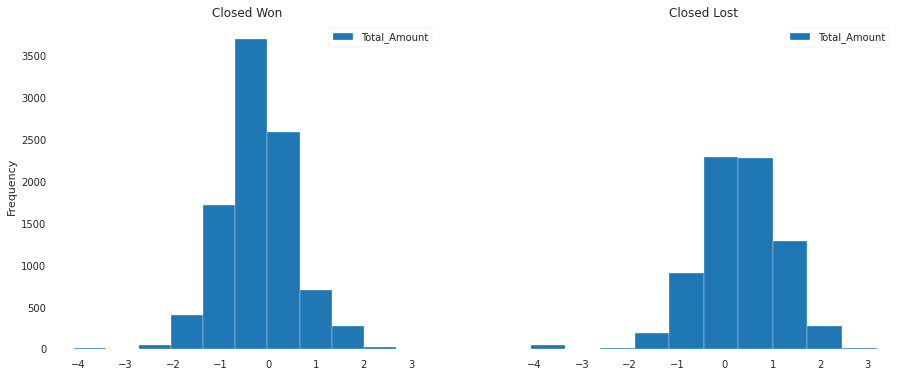

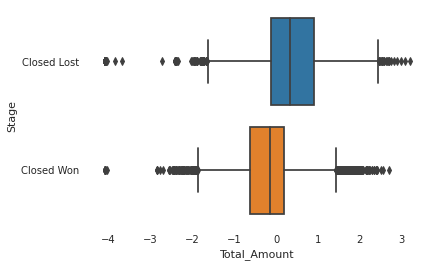

In [27]:
vz.plot_summary_total_amount(d)

Cuando hagamos es scaling, vamos a tener encuenta esta propuesta.

### Territorio by Region: imputando manual

- los que tienen Region americas, algunos están en otros continentes: americas_territory=["SW America", "South America", "SE America", "Central America"]
    - Modificamos esa region
- Algunos tienen Region Middle East, algunos están en otros continentes: dubai_territory=["UAE (Dubai)"]


In [28]:
# visualizamos por region, que territorios los componen
df_train[["Region","Territory"]]\
    .drop_duplicates()\
    .groupby('Region')\
    .apply(lambda d: d[["Territory"]].drop_duplicates())

Territory
Region                                 
APAC        23                    India
            260               Singapore
            280             Philippines
            520                Thailand
            593             South Korea
            615               Australia
            914                Cambodia
            928               Indonesia
            942             China (PRC)
            2063                 Taiwan
            2706        South East Asia
            4155        Solomon Islands
            4156                Vietnam
            5721               Malaysia
            9235            New Zealand
            12259                 Burma
            17461              Mongolia
Americas    2                NW America
            132              NE America
            209              SE America
            287              SW America
            409                     NaN
            7400                 Canada
            7487             Central US
            7489              Carribean
            18487         South America
EMEA        0                       NaN
            62                    Italy
            63                  Germany
            66           United Kingdom
            78              UAE (Dubai)
            81                   Greece
            83              Switzerland
            85                  Austria
            134                 Belgium
            181                 Tunisia
            212                  France
            213                   Spain
            406                 Denmark
            407         Central America
            436                  Poland
            445                  Norway
            590                Portugal
            669             Netherlands
            773              SE America
            1053                Ireland
            1080                 Cyprus
            1129                Morocco
            1559                 Turkey
            1567                 Sweden
            1625                 Monaco
            1657             Kazakhstan
            1817                Romania
            1879                Hungary
            1931                 Jordan
            2384          South America
            3190              Macedonia
            3348                Ukraine
            3768         Czech Republic
            4093                Belarus
            4794   Bosnia & Herzegovina
            4816                 Kosovo
            5198             Luxembourg
            5270               Bulgaria
            5475                Armenia
            5667                Croatia
            6140                Georgia
            6882                Estonia
            8979                  Malta
            10976               Albania
            14136              Slovenia
            15192                   KSA
            16143                 Egypt
            16158                Kuwait
            16178            SW America
            17218               Andorra
            17404               Finland
Japan       8                       NaN
            139                   Japan
Middle East 745                  Kuwait
            994                     KSA
            998                     NaN
            999             UAE (Dubai)
            1078                 Jordan
            4675           Saudi Arabia
            5402           UAE (Others)
            7331               Pakistan
            12207                  Oman
            15512               Lebanon

In [29]:
# cuantos territorios por region y cuales.
df_train[["Region","Territory"]]\
    .groupby('Region')\
    .agg({ "Territory":["nunique", "size"]})

Territory      
              nunique  size
Region                     
APAC               17  3744
Americas            8  4961
EMEA               50  5502
Japan               1  5093
Middle East         9   198

Imputo territorio Japan con los que tienen region Japan

In [30]:
df_train = bf.impute_japan_territory(df_train)

In [31]:
df_train = bf.impute_americas_region(df_train)

In [32]:
df_train = bf.impute_dubai_region(df_train)

In [33]:
# visualizamos por region, que territorios los componen
df_train[["Region","Territory"]]\
    .drop_duplicates()\
    .groupby('Region')\
    .apply(lambda d: d[["Territory"]].drop_duplicates())

Territory
Region                                 
APAC        23                    India
            260               Singapore
            280             Philippines
            520                Thailand
            593             South Korea
            615               Australia
            914                Cambodia
            928               Indonesia
            942             China (PRC)
            2063                 Taiwan
            2706        South East Asia
            4155        Solomon Islands
            4156                Vietnam
            5721               Malaysia
            9235            New Zealand
            12259                 Burma
            17461              Mongolia
Americas    2                NW America
            132              NE America
            209              SE America
            287              SW America
            407         Central America
            409                     NaN
            2384          South America
            7400                 Canada
            7487             Central US
            7489              Carribean
EMEA        0                       NaN
            62                    Italy
            63                  Germany
            66           United Kingdom
            81                   Greece
            83              Switzerland
            85                  Austria
            134                 Belgium
            181                 Tunisia
            212                  France
            213                   Spain
            406                 Denmark
            436                  Poland
            445                  Norway
            590                Portugal
            669             Netherlands
            1053                Ireland
            1080                 Cyprus
            1129                Morocco
            1559                 Turkey
            1567                 Sweden
            1625                 Monaco
            1657             Kazakhstan
            1817                Romania
            1879                Hungary
            1931                 Jordan
            3190              Macedonia
            3348                Ukraine
            3768         Czech Republic
            4093                Belarus
            4794   Bosnia & Herzegovina
            4816                 Kosovo
            5198             Luxembourg
            5270               Bulgaria
            5475                Armenia
            5667                Croatia
            6140                Georgia
            6882                Estonia
            8979                  Malta
            10976               Albania
            14136              Slovenia
            15192                   KSA
            16143                 Egypt
            16158                Kuwait
            17218               Andorra
            17404               Finland
Japan       8                     Japan
Middle East 78              UAE (Dubai)
            745                  Kuwait
            994                     KSA
            998                     NaN
            1078                 Jordan
            4675           Saudi Arabia
            5402           UAE (Others)
            7331               Pakistan
            12207                  Oman
            15512               Lebanon

### Source
Eliminamos esta columna
- missings: 56.0%
- drop/fillna?

In [34]:
df_train = df_train.drop(columns="Source ")

In [35]:
df_train.columns[df_train.isna().any()]

Index(['Territory', 'Billing_Country', 'Account_Type', 'Quote_Expiry_Date',
       'Planned_Delivery_End_Date'],
      dtype='object')

### Planned_Delivery_End_Date
Una fecha tiene un error de tipeo => 2208 a 2018, se puede salvar.

In [36]:
df_train.loc[
    (df_train.Planned_Delivery_End_Date.dt.year == 2208), 
    ["Planned_Delivery_End_Date"]
] = pd.to_datetime('20181231', format='%Y%m%d', errors='ignore')

Observamos la diferencia entre los Planned start y end date, cuando Planned_xxx_End_Date

In [37]:
nn = df_train[~df_train.Planned_Delivery_End_Date.isna()]
(nn.Planned_Delivery_End_Date - nn.Planned_Delivery_Start_Date).value_counts().nlargest(10) # verificamos que diferencia es la más probable/frecuente

0 days     8257
4 days     1836
30 days     744
11 days     609
29 days     569
18 days     364
7 days      350
3 days      325
25 days     322
28 days     316
dtype: int64

In [38]:
# imputo con 4 dias
impute_planned_days = 4

In [39]:
df_train = bf.impute_planned_end_date(df_train, impute_planned_days)

### Quote_Expiry_Date

Busco el promedio de la diferencia entre Quote_Expiry_Date y Opportunity_Created_Date, discretizado por  Stage; e imputamos.


In [40]:
nn = df_train[~(df_train.Quote_Expiry_Date.isna()) & (df_train.Stage == 'Closed Won')]
days = (nn.Quote_Expiry_Date - nn.Opportunity_Created_Date)
print("Closed Won - Quote Range: {:.4f} +/-{:.4f} ".format(days.dt.days.mean(), days.dt.days.std()))

nn = df_train[~(df_train.Quote_Expiry_Date.isna()) & (df_train.Stage != 'Closed Won')]
days = (nn.Quote_Expiry_Date - nn.Opportunity_Created_Date)
print("NOT Closed Won - Quote Range: {:.4f} +/-{:.4f} ".format(days.dt.days.mean(), days.dt.days.std()))


Closed Won - Quote Range: 33.7976 +/-56.6878 
NOT Closed Won - Quote Range: 64.3115 +/-95.5006 


In [41]:
# busco las que no tienen na
nn = df_train[~df_train.Quote_Expiry_Date.isna()]

# el promedio de los que se venden está en 30, y los que no se venden en 70. 
mean_expiry_created = (nn.Quote_Expiry_Date - nn.Opportunity_Created_Date).dt.days.mean()
print("Imputamos con: ", mean_expiry_created)

Imputamos con:  46.28781990173792


In [42]:
df_train = bf.impute_quote_Expiry_Date(df_train, mean_expiry_created)

### Billing_Country
- Verificamos valores de region y territory

In [43]:
# cuantos territorios y cuantos Billing_country nan hay.
df_train[df_train.train==1][["Territory","Billing_Country"]].isna().sum(axis=0) 

Territory          788
Billing_Country     27
dtype: int64

In [44]:
df_train[df_train.train==0][["Territory","Billing_Country"]].isna().sum(axis=0) 

Territory          65
Billing_Country     1
dtype: int64

Vamos a buscar el territorio mas probable por region y vamos a imputar Billing_Country con esos resultados

In [45]:
# Territorios que tienen Billing_Country en na
territory_valid = df_train[(df_train.Billing_Country.isna()) & ~(df_train.Territory.isna())].Territory

print("Territorios que tienen Billing_country en nan: ", territory_valid.unique())

Territorios que tienen Billing_country en nan:  ['India' 'Tunisia' 'Japan' 'Singapore' 'United Kingdom' 'Indonesia'
 'Germany' 'Philippines' 'Cambodia' 'Poland' 'Thailand']


In [46]:
# los billing_country que más aparecen por territorios que tienen al menos 1 billing_country en na
df_train[["Territory", "Billing_Country",]][(df_train.Territory.isin(territory_valid))]\
    .groupby('Territory')\
    .Billing_Country\
    .value_counts(normalize=True)\
    .to_frame()

Billing_Country
Territory      Billing_Country                                        
Cambodia       Cambodia                                       0.750000
               Germany                                        0.250000
Germany        Germany                                        0.988741
               Luxembourg                                     0.002559
               Switzerland                                    0.002559
               United Kingdom                                 0.001535
               United States                                  0.001535
               Hungary                                        0.001024
               Denmark                                        0.000512
               Ghana                                          0.000512
               Netherlands                                    0.000512
               Poland                                         0.000512
India          India                                          0.827624
               Sri Lanka                                      0.138122
               Pakistan                                       0.011050
               Singapore                                      0.006630
               Bangladesh                                     0.004420
               Norway                                         0.004420
               Canada                                         0.002210
               Korea, Republic of                             0.002210
               Belize                                         0.001105
               France                                         0.001105
               Germany                                        0.001105
Indonesia      Indonesia                                      0.937888
               Germany                                        0.018634
               Singapore                                      0.018634
               Spain                                          0.012422
               Philippines                                    0.006211
               United Arab Emirates                           0.006211
Japan          Japan                                          0.996661
               Singapore                                      0.001964
               United Kingdom                                 0.000786
               Germany                                        0.000196
               India                                          0.000196
               Korea, Democratic People's Republic of         0.000196
Philippines    Philippines                                    0.882353
               Singapore                                      0.092437
               Germany                                        0.025210
Poland         Poland                                         0.787879
               Germany                                        0.151515
               Austria                                        0.030303
               Hungary                                        0.030303
Singapore      Singapore                                      0.890152
               Philippines                                    0.079545
               Norway                                         0.009470
               Japan                                          0.007576
               Germany                                        0.005682
               China                                          0.003788
               Indonesia                                      0.001894
               Viet Nam                                       0.001894
Thailand       Thailand                                       0.971014
               Singapore                                      0.024155
               Italy                                          0.004831
Tunisia        France                                         0.750000
               Germany                                        0.250000
United K

El único que no tiene Billing_Country igual al territorio al menos una vez es Tunisia.
Pero el 75% de las veces, es Francia.

In [47]:
impute_billing_by_territory = df_train[[ "Territory", "Billing_Country",]][(df_train.Territory.isin(territory_valid))]\
    .groupby('Territory').Billing_Country\
    .value_counts(normalize=True)\
    .to_frame().groupby(level=[0])\
    .idxmax().Billing_Country.values
impute_billing_by_territory = dict(impute_billing_by_territory)

In [48]:
impute_billing_by_territory

{'Cambodia': 'Cambodia',
 'Germany': 'Germany',
 'India': 'India',
 'Indonesia': 'Indonesia',
 'Japan': 'Japan',
 'Philippines': 'Philippines',
 'Poland': 'Poland',
 'Singapore': 'Singapore',
 'Thailand': 'Thailand',
 'Tunisia': 'France',
 'United Kingdom': 'United Kingdom'}

In [49]:
df_train = bf.impute_billing_country(df_train, impute_billing_by_territory)

In [50]:
df_train[df_train.Billing_Country.isna()]

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,Account_Name,Opportunity_ID,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Product_Family,Product_Name,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,train,has_contract,rate,ASP_was_converted,Total_Amount_Imputed,Planned_Delivery_End_Date_Imputed,Quote_Expiry_Date_Imputed,Billing_Country_Imputed
16144,EMEA,NaN,0,0,0,0,Bureaucratic_Code_4,2014-03-27,NaN,Account_Name_2054,12392,Person_Name_20,Person_Name_20,Account_Type_2,Opportunity_Type_19,Delivery_Terms_2,2014-12-13,2015-02-15,2015-11-27,Product_Family_85,Product_Name_109,2016-01-31,2016-03-29,20,EUR,7202422.26,EUR,0.0,Closed Lost,1,0,0.884099,True,1,False,False,False


Nos queda sin imputar esta row que no tiene territorio cargado

### Territory: modelito
- Imputamos con Region y Billing_Country, entrenamos un modelito e imputamos
    - Agrego la columna Territory_Imputed que indica la probabilidad del imputado. Un -1 significa que no fue imputado.

In [51]:
df_train.Territory.isna().sum()

853

In [52]:
df_train = bf.impute_territory_nan(df_train)

/home/jloscalzo/Projects/py-ml/air_cond_AlixSadosky/aircond_alix_sadosky/src/features/build_features.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fm = RandomForestClassifier(random_state=42).fit(fx, fy)


Métrica logLoss: 0.10943198878455362


In [53]:
df_train.loc[df_train.Territory_Imputed >= 0, ["Territory", "Territory_Imputed"]].sample(10)

,Territory,Territory_Imputed
5511,NE America,0.740499
8477,SE America,0.998750
15088,NW America,1.000000
7900,NE America,1.000000
14458,Central US,0.742451
10484,SW America,0.970000
16817,Canada,0.597408
10372,SW America,0.931765
3198,Netherlands,0.927799
17533,NW America,1.000000


Buscamos los territorios que completamos y que además no tenían billing_country; es decir: territory:na & billing_country:na.

In [54]:
billing_country_na_yet_mask = df_train.Billing_Country.isna()
df_train.loc[billing_country_na_yet_mask, ["Territory", "Territory_Imputed"]]

,Territory,Territory_Imputed
16144,Germany,0.14


In [55]:
territories = df_train[df_train.Billing_Country.isna()].Territory

for territory in territories.values: 
    if territory in impute_billing_by_territory:
        impute_billing_by_territory[territory] = df_train[df_train.Territory.isin([territory])].Billing_Country.value_counts().idxmax()

In [56]:
df_train = bf.impute_billing_country(df_train, impute_billing_by_territory)

In [57]:
df_train.loc[billing_country_na_yet_mask, ["Territory", "Billing_Country", "Territory_Imputed"]]

,Territory,Billing_Country,Territory_Imputed
16144,Germany,Germany,0.14


In [58]:
df_train = df_train.drop(columns='Account_Name')

## Feature Engineering 

### Rango: Planned_Range_days

In [59]:
def create_diff_planned_days(df):
    days = (df.Planned_Delivery_End_Date - df.Planned_Delivery_Start_Date).dt.days
    df['Planned_Range_days'] = days
    return df

In [60]:
create_diff_planned_days(df_train)

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,Opportunity_ID,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Product_Family,Product_Name,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,train,has_contract,rate,ASP_was_converted,Total_Amount_Imputed,Planned_Delivery_End_Date_Imputed,Quote_Expiry_Date_Imputed,Billing_Country_Imputed,Territory_Imputed,Planned_Range_days
0,EMEA,Netherlands,1,1,1,1,Bureaucratic_Code_4,2015-06-16,Netherlands,0,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,2015-12-07,2016-01-30 00:00:00.000000,2016-06-13,Product_Family_77,Product_Name_99,2016-05-01,2016-06-30,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,1,0,0.884100,True,-1,False,False,False,1.0,60
1,EMEA,Netherlands,0,0,0,0,Bureaucratic_Code_4,2015-06-16,Netherlands,1,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,2015-12-07,2016-01-20 00:00:00.000000,2016-01-15,Product_Family_77,Product_Name_100,2016-01-18,2016-01-20,0,EUR,48230.0,EUR,48230.0,Closed Won,1,1,0.884101,True,-1,False,False,False,1.0,2
2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,United States,2,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Delivery_Terms_4,2015-12-08,2016-09-30 00:00:00.000000,2016-09-29,Product_Family_81,Product_Name_91,2016-01-25,2016-01-25,0,USD,83865.6,USD,83865.6,Closed Won,1,1,1.000000,False,-1,False,False,False,-1.0,0
3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,3,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,2015-12-08,2016-01-23 06:54:27.639510,2018-03-27,Product_Family_209,Product_Name_432,2018-02-01,2018-03-31,14,USD,7421881.5,USD,7421881.5,Closed Lost,1,0,1.000000,False,-1,False,True,False,-1.0,58
4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,4,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,2015-12-08,2017-06-02 00:00:00.000000,2018-03-27,Product_Family_209,Product_Name_432,2018-02-01,2018-02-28,25,USD,13357192.5,USD,13357192.5,Closed Lost,1,0,1.000000,False,-1,False,False,False,-1.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19493,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,South Africa,12364,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Delivery_Terms_7,2019-04-26,2019-05-24 00:00:00.000000,2019-04-26,Product_Family_213,Product_Name_447,2019-05-01,2019-05-10,0,USD,124740.0,USD,147750.0,None,0,1,1.000000,False,-1,False,False,False,-1.0,9
19494,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,United States,12365,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Delivery_Terms_4,2019-04-26,2019-05-24 00:00:00.000000,2019-04-27,Product_Family_221,Product_Name_477,2019-10-01,2019-12-31,0,USD,45054.9,USD,45054.9,None,0,1,1.000000,False,-1,False,False,False,-1.0,91
19495,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,United States,12366,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Delivery_Terms_4,2019-04-26,2019-05-24 00:00:00.000000,2019-04-27,Product_Family_221,Product_Name_477,2019-10-01,2019-12-31,0,USD,100122.0,USD,100122.0,None,0,1,1.000000,False,-1,False,False,False,-1.0,91
19496,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,United States,12367,Person_Name_9,Person_Name_9,Account_Type_2,Opportunity_Type_7,Delivery_Terms_4,2019-04-26,2019-05-26 00:00:00.000000,2019-04-26,Product_Family_156,Product_Name_281,2019-08-01,2019-08-01,0,USD,143220.0,USD,143220.0,None,0,0,1.000000,False,-1,False,F

### Rango: Quota_Range_days

In [61]:
def create_diff_quota_days(df):
    days = (df.Quote_Expiry_Date - df.Opportunity_Created_Date).dt.days
    df['Quote_Range_days'] = days
    return df

In [62]:
create_diff_quota_days(df_train)

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,Opportunity_ID,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Product_Family,Product_Name,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,train,has_contract,rate,ASP_was_converted,Total_Amount_Imputed,Planned_Delivery_End_Date_Imputed,Quote_Expiry_Date_Imputed,Billing_Country_Imputed,Territory_Imputed,Planned_Range_days,Quote_Range_days
0,EMEA,Netherlands,1,1,1,1,Bureaucratic_Code_4,2015-06-16,Netherlands,0,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,2015-12-07,2016-01-30 00:00:00.000000,2016-06-13,Product_Family_77,Product_Name_99,2016-05-01,2016-06-30,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,1,0,0.884100,True,-1,False,False,False,1.0,60,54
1,EMEA,Netherlands,0,0,0,0,Bureaucratic_Code_4,2015-06-16,Netherlands,1,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,2015-12-07,2016-01-20 00:00:00.000000,2016-01-15,Product_Family_77,Product_Name_100,2016-01-18,2016-01-20,0,EUR,48230.0,EUR,48230.0,Closed Won,1,1,0.884101,True,-1,False,False,False,1.0,2,44
2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,United States,2,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Delivery_Terms_4,2015-12-08,2016-09-30 00:00:00.000000,2016-09-29,Product_Family_81,Product_Name_91,2016-01-25,2016-01-25,0,USD,83865.6,USD,83865.6,Closed Won,1,1,1.000000,False,-1,False,False,False,-1.0,0,297
3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,3,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,2015-12-08,2016-01-23 06:54:27.639510,2018-03-27,Product_Family_209,Product_Name_432,2018-02-01,2018-03-31,14,USD,7421881.5,USD,7421881.5,Closed Lost,1,0,1.000000,False,-1,False,True,False,-1.0,58,46
4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,4,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,2015-12-08,2017-06-02 00:00:00.000000,2018-03-27,Product_Family_209,Product_Name_432,2018-02-01,2018-02-28,25,USD,13357192.5,USD,13357192.5,Closed Lost,1,0,1.000000,False,-1,False,False,False,-1.0,27,542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19493,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,South Africa,12364,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Delivery_Terms_7,2019-04-26,2019-05-24 00:00:00.000000,2019-04-26,Product_Family_213,Product_Name_447,2019-05-01,2019-05-10,0,USD,124740.0,USD,147750.0,None,0,1,1.000000,False,-1,False,False,False,-1.0,9,28
19494,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,United States,12365,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Delivery_Terms_4,2019-04-26,2019-05-24 00:00:00.000000,2019-04-27,Product_Family_221,Product_Name_477,2019-10-01,2019-12-31,0,USD,45054.9,USD,45054.9,None,0,1,1.000000,False,-1,False,False,False,-1.0,91,28
19495,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,United States,12366,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Delivery_Terms_4,2019-04-26,2019-05-24 00:00:00.000000,2019-04-27,Product_Family_221,Product_Name_477,2019-10-01,2019-12-31,0,USD,100122.0,USD,100122.0,None,0,1,1.000000,False,-1,False,False,False,-1.0,91,28
19496,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,United States,12367,Person_Name_9,Person_Name_9,Account_Type_2,Opportunity_Type_7,Delivery_Terms_4,2019-04-26,2019-05-26 00:00:00.000000,2019-04-26,Product_Family_156,Product_Name_281,2019-08-01,2019-08-01,0,USD,143220.0,

### Rango: Modify_Range_days

In [63]:
def create_diff_modified_days(df):
    days = (df.Last_Modified_Date - df.Opportunity_Created_Date).dt.days
    df['Modify_Range_days'] = days
    return df

In [64]:
create_diff_modified_days(df_train)

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,Opportunity_ID,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Product_Family,Product_Name,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,train,has_contract,rate,ASP_was_converted,Total_Amount_Imputed,Planned_Delivery_End_Date_Imputed,Quote_Expiry_Date_Imputed,Billing_Country_Imputed,Territory_Imputed,Planned_Range_days,Quote_Range_days,Modify_Range_days
0,EMEA,Netherlands,1,1,1,1,Bureaucratic_Code_4,2015-06-16,Netherlands,0,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,2015-12-07,2016-01-30 00:00:00.000000,2016-06-13,Product_Family_77,Product_Name_99,2016-05-01,2016-06-30,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,1,0,0.884100,True,-1,False,False,False,1.0,60,54,189
1,EMEA,Netherlands,0,0,0,0,Bureaucratic_Code_4,2015-06-16,Netherlands,1,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,2015-12-07,2016-01-20 00:00:00.000000,2016-01-15,Product_Family_77,Product_Name_100,2016-01-18,2016-01-20,0,EUR,48230.0,EUR,48230.0,Closed Won,1,1,0.884101,True,-1,False,False,False,1.0,2,44,39
2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,United States,2,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Delivery_Terms_4,2015-12-08,2016-09-30 00:00:00.000000,2016-09-29,Product_Family_81,Product_Name_91,2016-01-25,2016-01-25,0,USD,83865.6,USD,83865.6,Closed Won,1,1,1.000000,False,-1,False,False,False,-1.0,0,297,296
3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,3,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,2015-12-08,2016-01-23 06:54:27.639510,2018-03-27,Product_Family_209,Product_Name_432,2018-02-01,2018-03-31,14,USD,7421881.5,USD,7421881.5,Closed Lost,1,0,1.000000,False,-1,False,True,False,-1.0,58,46,840
4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,4,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,2015-12-08,2017-06-02 00:00:00.000000,2018-03-27,Product_Family_209,Product_Name_432,2018-02-01,2018-02-28,25,USD,13357192.5,USD,13357192.5,Closed Lost,1,0,1.000000,False,-1,False,False,False,-1.0,27,542,840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19493,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,South Africa,12364,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Delivery_Terms_7,2019-04-26,2019-05-24 00:00:00.000000,2019-04-26,Product_Family_213,Product_Name_447,2019-05-01,2019-05-10,0,USD,124740.0,USD,147750.0,None,0,1,1.000000,False,-1,False,False,False,-1.0,9,28,0
19494,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,United States,12365,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Delivery_Terms_4,2019-04-26,2019-05-24 00:00:00.000000,2019-04-27,Product_Family_221,Product_Name_477,2019-10-01,2019-12-31,0,USD,45054.9,USD,45054.9,None,0,1,1.000000,False,-1,False,False,False,-1.0,91,28,1
19495,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,United States,12366,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Delivery_Terms_4,2019-04-26,2019-05-24 00:00:00.000000,2019-04-27,Product_Family_221,Product_Name_477,2019-10-01,2019-12-31,0,USD,100122.0,USD,100122.0,None,0,1,1.000000,False,-1,False,False,False,-1.0,91,28,1
19496,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,United States,12367,Person_Name_9,Person_Name_9,Account_Type_2,Opportunity_Type_7,Delivery_Terms_4,2019-04-26,2019-05-26 00:00:00.000000,2019-04-26,Product_Family_156,Product

### Total Amount Converted Y Taxable Converted

In [65]:
(df_train[df_train.train==1].Total_Amount== 0).sum(), df_train[df_train.train==0].rate.isna().sum(), df_train.Total_Taxable_Amount.isna().sum()

(52, 0, 0)

In [66]:
def amount_converted_fi(df):
    df.loc[:, "Total_Amount_Converted"] = df.Total_Amount * df.rate
    df.loc[:, "Total_Taxable_Amount_Converted"] = df.Total_Taxable_Amount * df.rate
    return df
    
df_train = amount_converted_fi(df_train)

### Total_Amount_Opportunity & Total_Amount_Converted_Opportunity
- En la notebook de aggregate, también se calcula,
    - "Total_Amount" es una suma cuando se hace el merge, lo mismo para converted
- Si se quiere utilizar el dataset por registro, no pisar.

In [67]:
def calc_total_amount_opp(df):
    df["Total_Amount_Opportunity"] = df.groupby('Opportunity_ID').Total_Amount.transform(sum)
    df["Total_Amount_Converted_Opportunity"] = df.groupby('Opportunity_ID').Total_Amount_Converted.transform(sum)
    return df
    

In [68]:
df_train = calc_total_amount_opp(df_train)

### Diff_Amount
- Calculamos la diferencia entre Total_Amount_Opportunity y Total_Amount_Converted_Opportunity
- En la notebook de aggregate, también se calcula,
    - "Diff_Amount" es una suma cuando se hace el merge, lo mismo para converted (verificar)

In [69]:
def calc_diff_amount(df):
    df["Diff_Amount"] = (df.Total_Amount_Opportunity - df.Total_Taxable_Amount).apply(np.log1p).fillna(0)
    df["Diff_Amount_converted"] = (df.Total_Amount_Converted_Opportunity - df.Total_Taxable_Amount_Converted).apply(np.log1p).fillna(0)
    return df


In [70]:
df_train = calc_diff_amount(df_train)
# df_train[df_train.train==0].Total_Amount.std()

In [71]:
df_train[df_train.Total_Amount_Converted.isna()].shape[0], df_train[df_train.Total_Amount.isna()].shape[0]

(0, 0)

### Apply Log to total_amount

In [72]:
def log_total_amount(df):
    df["Total_Amount"] = df.loc[:, "Total_Amount"].apply(np.log1p)
    df["Total_Taxable_Amount"] = df.loc[:, "Total_Taxable_Amount"].apply(np.log1p)
        
    df["Total_Amount_Converted"] = df.loc[:, "Total_Amount_Converted"].apply(np.log1p)
    df["Total_Taxable_Amount_Converted"] = df.loc[:, "Total_Taxable_Amount_Converted"].apply(np.log1p)
    return df

In [73]:
df_train = log_total_amount(df_train)

### Drop Total_Amount y Total_Amount_Converted

In [74]:
df_train = df_train.drop(columns=["Total_Amount", "Total_Amount_Converted"])

### Opportunities_by_Owner
- contabilizamos cuantas oportunidades en total tiene un Owner

In [75]:
def opportunities_by_owner(df):
    op_by_owner = df.groupby("Opportunity_Owner").Opportunity_ID.nunique().to_frame().rename(columns={"Opportunity_ID":"Opportunities_By_Owner"})
    return df.merge(op_by_owner, left_on='Opportunity_Owner', right_index=True, how='left')

In [76]:
df_train = opportunities_by_owner(df_train)

### Opportunity_History_by_Owner
- Asignamos el número de oportunidad correspondiente según fechas por owner
    - Cuantas veces pidió una oportunidad

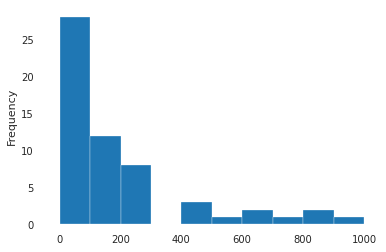

In [77]:
df_train.groupby(["Opportunity_Owner"]).Opportunity_ID.nunique().plot.hist()

In [78]:
def opportunity_history_by_owner(df):
    d = df.loc[:, ["Opportunity_Owner", "Opportunity_ID", "Opportunity_Created_Date"]]\
        .drop_duplicates()\
        .sort_values(by=["Opportunity_Owner", "Opportunity_Created_Date", "Opportunity_ID"])

    d["Opportunity_History_by_Owner"] = d.groupby("Opportunity_Owner")["Opportunity_ID"].transform(lambda df: pd.Series(range(len(df)), name="Opportunity_History"))

    return df.merge(d.drop(columns=["Opportunity_Created_Date"]), on=["Opportunity_Owner", "Opportunity_ID"])

In [79]:
df_train.Opportunity_Created_Date.min(), df_train[df_train.train == 1].Opportunity_Created_Date.max()

(Timestamp('2013-11-05 00:00:00'), Timestamp('2018-12-29 00:00:00'))

In [80]:
df_train = opportunity_history_by_owner(df_train)

### Opportunity_Created_Date_weight
Con la fecha más vieja, imputo en días para darle un peso. (cuanto más nuevo, más grande)

In [81]:
def date_weight(df):
    df['Opportunity_Created_Date_weight'] = (df.Opportunity_Created_Date - df.Opportunity_Created_Date.min()).dt.days
    df['Opportunity_Created_Date_weight_log'] = np.log1p((df.Opportunity_Created_Date - df.Opportunity_Created_Date.min()).dt.days)
    return df
    
df_train = date_weight(df_train)

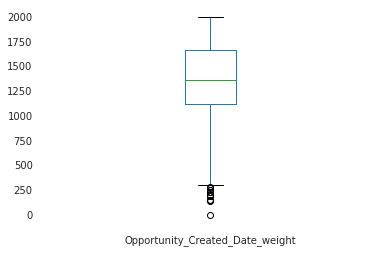

In [82]:
df_train.Opportunity_Created_Date_weight.plot.box()

### Dates
- se crean
    - Quota_Range: Quote_Expiry_Date - Opportunity_Created_Date
    - Planned_Range:  Planned_Delivery_End_Date - Planned_Delivery_Start_Date
    - Modify_Range_days: Last_Modified_Date - Opportunity_Created_Date 
    
vamos a derivar: 
- year-month
- month
- quarter
<!-- - quantil? -->

In [83]:
dt_columns = df_train.select_dtypes("datetime").columns
dt_columns

Index(['Account_Created_Date', 'Opportunity_Created_Date', 'Quote_Expiry_Date',
       'Last_Modified_Date', 'Planned_Delivery_Start_Date',
       'Planned_Delivery_End_Date'],
      dtype='object')

In [84]:
def create_fi_date(df, col):
    month = df[col].dt.month
    year = df[col].dt.year
    quarter = df[col].dt.quarter
    df.loc[:,col+"_Period"] = year*100+month
    df.loc[:,col+"_Year"] = year
    df.loc[:,col+"_Month"] = month
    
    df.loc[:,col+"_Q1_Quarter"] = (quarter==1).astype('int')
    df.loc[:,col+"_Q2_Quarter"] = (quarter==2).astype('int')
    df.loc[:,col+"_Q3_Quarter"] = (quarter==3).astype('int')
    df.loc[:,col+"_Q4_Quarter"] = (quarter==4).astype('int')
    
    return df.drop(columns=col)

In [85]:
for dt in dt_columns:
    df_train = create_fi_date(df_train, dt)
#     df_val = create_fi_date(df_val, dt)

In [86]:
# no remover hasta reagrupar.
labels = df_train[["Stage", "train"]]
df_train = df_train.drop(columns=["Stage"])

df_train.train.value_counts()

1    16947
0     2551
Name: train, dtype: int64

### Imputamos faltantes
- en esta instancia, no debería haber faltantes pero en caso de que existan (hay solo 1), imputamos con el más frecuente.

In [87]:
df_train[df_train.train == 1].isna().sum(axis=0)

Region                                      0
Territory                                   0
Pricing, Delivery_Terms_Quote_Appr          0
Pricing, Delivery_Terms_Approved            0
Bureaucratic_Code_0_Approval                0
Bureaucratic_Code_0_Approved                0
Bureaucratic_Code                           0
Billing_Country                             0
Opportunity_ID                              0
Account_Owner                               0
Opportunity_Owner                           0
Account_Type                              112
Opportunity_Type                            0
Delivery_Terms                              0
Product_Family                              0
Product_Name                                0
TRF                                         0
Total_Amount_Currency                       0
Total_Taxable_Amount_Currency               0
Total_Taxable_Amount                        0
train                                       0
has_contract                      

In [88]:
numeric_columns = list(df_train.select_dtypes(include='number').columns)
other_columns = list(df_train.select_dtypes(exclude='number').columns)

numeric_columns, other_columns
# df_train.info()

(['Pricing, Delivery_Terms_Quote_Appr',
  'Pricing, Delivery_Terms_Approved',
  'Bureaucratic_Code_0_Approval',
  'Bureaucratic_Code_0_Approved',
  'Opportunity_ID',
  'TRF',
  'Total_Taxable_Amount',
  'train',
  'has_contract',
  'rate',
  'Total_Amount_Imputed',
  'Territory_Imputed',
  'Planned_Range_days',
  'Quote_Range_days',
  'Modify_Range_days',
  'Total_Taxable_Amount_Converted',
  'Total_Amount_Opportunity',
  'Total_Amount_Converted_Opportunity',
  'Diff_Amount',
  'Diff_Amount_converted',
  'Opportunities_By_Owner',
  'Opportunity_History_by_Owner',
  'Opportunity_Created_Date_weight',
  'Opportunity_Created_Date_weight_log',
  'Account_Created_Date_Period',
  'Account_Created_Date_Year',
  'Account_Created_Date_Month',
  'Account_Created_Date_Q1_Quarter',
  'Account_Created_Date_Q2_Quarter',
  'Account_Created_Date_Q3_Quarter',
  'Account_Created_Date_Q4_Quarter',
  'Opportunity_Created_Date_Period',
  'Opportunity_Created_Date_Year',
  'Opportunity_Created_Date_Month',


se imputan faltantes para númericas y resto

In [89]:
ct_imputer = ColumnTransformer([
    ("numeric_imputer", SimpleImputer(strategy='mean'), numeric_columns),
    ("categorical_imputer", SimpleImputer(strategy='constant', fill_value='None'), other_columns)
])

In [90]:
_ = ct_imputer.fit(df_train)

In [91]:
df_train = ct_imputer.transform(df_train)

Se recrea el df

In [92]:
df_train = pd.DataFrame(df_train, columns=numeric_columns+other_columns)
# df_train.columns

### Product: stats
- calcular cantidad de productos que se venden en una oportunidad
- calcular cantidad de productos distintos de una oportunidad
- calcular cantidad de distintas familias de una oportunidad

In [93]:
def product_fi_stats(df):
    product_count = df.groupby('Opportunity_ID').Product_Name.nunique().rename("Product_Count").to_frame().reset_index()
    product_distinct_count = df.groupby('Opportunity_ID').Product_Name.count().rename("Product_Distinct_Count").to_frame().reset_index()
    family_distinct_count = df.groupby('Opportunity_ID').Product_Family.nunique().rename("Family_Distinct_Count").to_frame().reset_index()
    return (
        df.drop(columns=["Product_Count","Product_Distinct_Count","Family_Distinct_Count"], errors='ignore')
        .merge(product_count, on='Opportunity_ID', how='left')
        .merge(product_distinct_count, on='Opportunity_ID', how='left')
        .merge(family_distinct_count, on='Opportunity_ID', how='left')
    )


In [94]:
df_train = product_fi_stats(df_train)
df_train.train.value_counts()

1.0    16947
0.0     2551
Name: train, dtype: int64

In [95]:
df_train.head(10)

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,TRF,Total_Taxable_Amount,train,has_contract,rate,Total_Amount_Imputed,Territory_Imputed,Planned_Range_days,Quote_Range_days,Modify_Range_days,Total_Taxable_Amount_Converted,Total_Amount_Opportunity,Total_Amount_Converted_Opportunity,Diff_Amount,Diff_Amount_converted,Opportunities_By_Owner,Opportunity_History_by_Owner,Opportunity_Created_Date_weight,Opportunity_Created_Date_weight_log,Account_Created_Date_Period,Account_Created_Date_Year,Account_Created_Date_Month,Account_Created_Date_Q1_Quarter,Account_Created_Date_Q2_Quarter,Account_Created_Date_Q3_Quarter,Account_Created_Date_Q4_Quarter,Opportunity_Created_Date_Period,Opportunity_Created_Date_Year,Opportunity_Created_Date_Month,Opportunity_Created_Date_Q1_Quarter,Opportunity_Created_Date_Q2_Quarter,Opportunity_Created_Date_Q3_Quarter,Opportunity_Created_Date_Q4_Quarter,Quote_Expiry_Date_Period,Quote_Expiry_Date_Year,Quote_Expiry_Date_Month,Quote_Expiry_Date_Q1_Quarter,Quote_Expiry_Date_Q2_Quarter,Quote_Expiry_Date_Q3_Quarter,Quote_Expiry_Date_Q4_Quarter,Last_Modified_Date_Period,Last_Modified_Date_Year,Last_Modified_Date_Month,Last_Modified_Date_Q1_Quarter,Last_Modified_Date_Q2_Quarter,Last_Modified_Date_Q3_Quarter,Last_Modified_Date_Q4_Quarter,Planned_Delivery_Start_Date_Period,Planned_Delivery_Start_Date_Year,Planned_Delivery_Start_Date_Month,Planned_Delivery_Start_Date_Q1_Quarter,Planned_Delivery_Start_Date_Q2_Quarter,Planned_Delivery_Start_Date_Q3_Quarter,Planned_Delivery_Start_Date_Q4_Quarter,Planned_Delivery_End_Date_Period,Planned_Delivery_End_Date_Year,Planned_Delivery_End_Date_Month,Planned_Delivery_End_Date_Q1_Quarter,Planned_Delivery_End_Date_Q2_Quarter,Planned_Delivery_End_Date_Q3_Quarter,Planned_Delivery_End_Date_Q4_Quarter,Region,Territory,Bureaucratic_Code,Billing_Country,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Delivery_Terms,Product_Family,Product_Name,Total_Amount_Currency,Total_Taxable_Amount_Currency,ASP_was_converted,Planned_Delivery_End_Date_Imputed,Quote_Expiry_Date_Imputed,Billing_Country_Imputed,Product_Count,Product_Distinct_Count,Family_Distinct_Count
0,1,1,1,1,0,10,15.4781,1,0,0.8841,-1,1,60,54,189,15.3549,5.2728e+06,4.66168e+06,0,0,781,12,762,6.63726,201506,2015,6,0,1,0,0,201512,2015,12,0,0,0,1,201601,2016,1,1,0,0,0,201606,2016,6,0,1,0,0,201605,2016,5,0,1,0,0,201606,2016,6,0,1,0,0,EMEA,Netherlands,Bureaucratic_Code_4,Netherlands,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,Product_Family_77,Product_Name_99,EUR,EUR,True,False,False,False,1,1,1
1,0,0,0,0,1,0,10.7838,1,1,0.884101,-1,1,2,44,39,10.6606,48230,42640.2,0,0,42,16,762,6.63726,201506,2015,6,0,1,0,0,201512,2015,12,0,0,0,1,201601,2016,1,1,0,0,0,201601,2016,1,1,0,0,0,201601,2016,1,1,0,0,0,201601,2016,1,1,0,0,0,EMEA,Netherlands,Bureaucratic_Code_4,Netherlands,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Delivery_Terms_2,Product_Family_77,Product_Name_100,EUR,EUR,True,False,False,False,1,1,1
2,0,0,0,0,2,0,11.337,1,1,1,-1,-1,0,297,296,11.337,83865.6,83865.6,0,0,857,50,763,6.63857,201504,2015,4,0,1,0,0,201512,2015,12,0,0,0,1,201609,2016,9,0,0,1,0,201609,2016,9,0,0,1,0,201601,2016,1,1,0,0,0,201601,2016,1,1,0,0,0,Americas,NW America,Bureaucratic_Code_4,United States,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Delivery_Terms_4,Product_Family_81,Product_Name_91,USD,USD,False,False,False,False,1,1,1
3,1,0,1,0,3,14,15.8199,1,0,1,-1,-1,58,46,840,15.8199,7.42188e+06,7.42188e+06,0,0,857,51,763,6.63857,201307,2013,7,0,0,1,0,201512,2015,12,0,0,0,1,201601,2016,1,1,0,0,0,201803,2018,3,1,0,0,0,201802,2018,2,1,0,0,0,201803,2018,3,1,0,0,0,Americas,NW America,Bureaucratic_Code_5,United States,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Delivery_Terms_1,Product_Family_209,Product_Name_432,USD,USD,False,False,True,False,1,1,1
4,1,0,1,0,4,25,16.4076,1,0,1,-1,-1,

### Product: family y name
- Se realizará un one-hot de product y family. 
- Las otras columnas no se modifican. 

In [96]:
clean_cols = df_train.columns[~df_train.columns.isin(["Product_Name", "Product_Family"])].to_numpy()

ct_product = ColumnTransformer([
    ("rest", 'passthrough', clean_cols),
    ("product_onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'), ["Product_Name", "Product_Family"]),
])

In [97]:
_ = ct_product.fit(df_train)

In [98]:
prod_cols = ct_product.transformers_[1][1].get_feature_names(["Product_Name", "Product_Family"])                                                    

In [99]:
cols = np.append(clean_cols, prod_cols)

In [100]:
df_train = pd.DataFrame(ct_product.transform(df_train), columns=cols)

In [101]:
# salvo data intermedia para trabajar en otro notebook
df_train.to_parquet(INTERMEDIATE_RESULTS, index=False)

In [102]:
df_train.train.value_counts()

1.0    16947
0.0     2551
Name: train, dtype: int64

### Agregación
- ejecutar la notebook 03-xxx con intermediate_results

In [103]:
# %%script false --no-raise-error
agg_train = pd.read_parquet(GROUP_INTERMEDIATE_RESULTS)
# agg_val = pd.read_parquet(os.path.join(DATA_DIR,"processed/intermediate_group_result_val.parquet"))

In [104]:
agg_train.shape

(11408, 778)

In [105]:
agg_train.Opportunity_ID.nunique(), df_train.Opportunity_ID.nunique()

(11408, 11408)

#### Merge
- Mergemos para obtener el nuevo dataframe wide
- TODO: 
    - revisar que las columnas sean las mismas
    - ver si arriba no se está totalizando, sino va a dar error
    - en agg notebook se calculan cuales son las columnas que "cambian" al agregar por oportunity_ID. 
    - Seguro es mejor práctica utilizar un script o pasarle una lista desde esta notebook y ejecutarla con papermill o similar.

In [106]:
df_train.train.value_counts()

1.0    16947
0.0     2551
Name: train, dtype: int64

In [107]:
df_train = bf.join_aggregates(df_train, agg_train)

In [108]:
df_train.train.value_counts()

1.0    9841
0.0    1567
Name: train, dtype: int64

### Restantes Columnas
Con las columnas restantes:
- Hay Columnas que van a pasar tal cual
- Hay unas númericas que van a ser escaladas
    - MinMaxScaler para columnas númericas
    - Vamos a probar con RobustScaler también, algunas ya fueron pasadas por logaritmos.
- One-Hot de las columnas categoricas con cardinalidad menor a 10 
- OrdinalEncoder de las columnas categoricas con cardinalidad mayor a 10
    - podríamos usar un "ordinal-count-encoder", contando cuantas veces aparece y colocando ese número.



In [109]:
'Product_Family' in df_train.columns.tolist(), 'Product_Name' in df_train.columns.tolist(), 

(False, False)

In [110]:
df_train.columns[~df_train.columns.str.contains("Product_Name|Product_Family")].tolist()

['Pricing, Delivery_Terms_Quote_Appr',
 'Pricing, Delivery_Terms_Approved',
 'Bureaucratic_Code_0_Approval',
 'Bureaucratic_Code_0_Approved',
 'Opportunity_ID',
 'Total_Taxable_Amount',
 'train',
 'has_contract',
 'rate',
 'Total_Amount_Imputed',
 'Territory_Imputed',
 'Quote_Range_days',
 'Modify_Range_days',
 'Total_Taxable_Amount_Converted',
 'Total_Amount_Opportunity',
 'Total_Amount_Converted_Opportunity',
 'Diff_Amount',
 'Diff_Amount_converted',
 'Opportunities_By_Owner',
 'Opportunity_History_by_Owner',
 'Opportunity_Created_Date_weight',
 'Opportunity_Created_Date_weight_log',
 'Account_Created_Date_Period',
 'Account_Created_Date_Year',
 'Account_Created_Date_Month',
 'Account_Created_Date_Q1_Quarter',
 'Account_Created_Date_Q2_Quarter',
 'Account_Created_Date_Q3_Quarter',
 'Account_Created_Date_Q4_Quarter',
 'Opportunity_Created_Date_Period',
 'Opportunity_Created_Date_Year',
 'Opportunity_Created_Date_Month',
 'Opportunity_Created_Date_Q1_Quarter',
 'Opportunity_Created_Dat

In [111]:
passthrough = [
    "train",
    "Opportunity_ID",
    'has_contract',
    "Bureaucratic_Code_0_Approval", 
    "Bureaucratic_Code_0_Approved",
    'Pricing, Delivery_Terms_Quote_Appr',
    'Pricing, Delivery_Terms_Approved',
    
    'Opportunities_By_Owner',
    'Opportunity_History_by_Owner',
    
    'Account_Created_Date_Period',
    'Account_Created_Date_Year',
    'Account_Created_Date_Month',
    "Account_Created_Date_Q1_Quarter",
    "Account_Created_Date_Q2_Quarter",
    "Account_Created_Date_Q3_Quarter",
    "Account_Created_Date_Q4_Quarter",
    
    
    'Opportunity_Created_Date_Period',
    'Opportunity_Created_Date_Year',
    'Opportunity_Created_Date_Month',
    "Opportunity_Created_Date_Q1_Quarter",
    "Opportunity_Created_Date_Q2_Quarter",
    "Opportunity_Created_Date_Q3_Quarter",
    "Opportunity_Created_Date_Q4_Quarter",
    
    'Quote_Expiry_Date_Period',
    'Quote_Expiry_Date_Year',
    'Quote_Expiry_Date_Month',
    "Quote_Expiry_Date_Q1_Quarter",
    "Quote_Expiry_Date_Q2_Quarter",
    "Quote_Expiry_Date_Q3_Quarter",
    "Quote_Expiry_Date_Q4_Quarter",
    
    "Last_Modified_Date_Period",
    "Last_Modified_Date_Year",
    "Last_Modified_Date_Month",
    "Last_Modified_Date_Q1_Quarter",
    "Last_Modified_Date_Q2_Quarter",
    "Last_Modified_Date_Q3_Quarter",
    "Last_Modified_Date_Q4_Quarter",
    
    'Planned_Range_days_mean',
    'Planned_Range_days_std',
    'Planned_Delivery_Start_Date_Period_mean',
    'Planned_Delivery_Start_Date_Period_std',
    'Planned_Delivery_Start_Date_Year_mean',
    'Planned_Delivery_Start_Date_Year_std',
    'Planned_Delivery_Start_Date_Month_mean',
    'Planned_Delivery_Start_Date_Month_std',
    'Planned_Delivery_End_Date_Period_mean',
    'Planned_Delivery_End_Date_Period_std',
    'Planned_Delivery_End_Date_Year_mean',
    'Planned_Delivery_End_Date_Year_std',
    'Planned_Delivery_End_Date_Month_mean',
    'Planned_Delivery_End_Date_Month_std',
    
    'Planned_Delivery_Start_Date_Q1_Quarter',
    'Planned_Delivery_Start_Date_Q2_Quarter',
    'Planned_Delivery_Start_Date_Q3_Quarter',
    'Planned_Delivery_Start_Date_Q4_Quarter',
    'Planned_Delivery_End_Date_Q1_Quarter',
    'Planned_Delivery_End_Date_Q2_Quarter',
    'Planned_Delivery_End_Date_Q3_Quarter',
    'Planned_Delivery_End_Date_Q4_Quarter',
    
    'Product_Count',
    'Product_Distinct_Count',
    'Family_Distinct_Count',
]

numeric_columns = [
    'TRF',
    'Quote_Range_days',
    "Modify_Range_days",
    'Diff_Amount',
    'Diff_Amount_converted',
    'Total_Amount_Opportunity',
    'Total_Amount_Converted_Opportunity',
#     'Total_Amount',
#     'Total_Amount_Converted',
    'Total_Taxable_Amount',
    'Total_Taxable_Amount_Converted',
    'Opportunity_Created_Date_weight',
]

categorical_columns = [
    'Region',
    'Territory',
    'Bureaucratic_Code',
    'Billing_Country',
    'Account_Owner',
    'Opportunity_Owner',
    'Account_Type',
    'Opportunity_Type',
    'Delivery_Terms',
    'Total_Amount_Currency',
    'Total_Taxable_Amount_Currency',
    'Total_Amount_Imputed', 
    'Territory_Imputed',
    'ASP_was_converted',
    'Quote_Expiry_Date_Imputed', 
    'Billing_Country_Imputed',
    'Planned_Delivery_End_Date_Imputed'
]

In [112]:
np.unique(prod_cols).shape[0] == prod_cols.shape[0]

True

In [113]:
feature_columns = np.unique(passthrough + numeric_columns + categorical_columns).tolist() + list(prod_cols)
len(feature_columns)

842

In [114]:
"Product_Name_Product_Name_137" in prod_cols

True

In [115]:
not_used_cols = df_train.columns[~df_train.columns.isin(feature_columns)]
not_used_cols

Index(['rate', 'Opportunity_Created_Date_weight_log'], dtype='object')

In [116]:
diff_columns = len(np.unique(passthrough + numeric_columns + categorical_columns).tolist() + list(np.unique(prod_cols))) - df_train.columns.shape[0]
print(diff_columns)

-2


In [117]:
if ( diff_columns < 0 ):
    df_train = df_train.drop(columns=not_used_cols.values)
else :
    print("Columnas que no están en train: ", [f for f in feature_columns if f not in df_train.columns])

In [118]:
df_train.shape

(11408, 842)

In [119]:
one_hot_columns = list((df_train[categorical_columns].nunique() <= 10)[lambda d: d==True].index)
encoder_columns = list((df_train[categorical_columns].nunique() > 10)[lambda d: d==True].index)

In [120]:
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

ct_transformations = ColumnTransformer([
    ("pass", 'passthrough', passthrough + list(prod_cols)),
    ("numeric_scaler", RobustScaler(), numeric_columns),
    ("categorical_onehot", OneHotEncoder(handle_unknown='ignore'), one_hot_columns),
    ("categorical_encoder", OrdinalEncoder(), encoder_columns)
])

Detalle: entrenamos con train, luego ejecutamos en el dataset completo

In [121]:
_=ct_transformations.fit(df_train[df_train.train==1])

In [122]:
actual_cols = passthrough + list(prod_cols) + numeric_columns + list(ct_transformations.transformers_[2][1].get_feature_names(one_hot_columns)) + encoder_columns

In [123]:
df_train = pd.DataFrame(ct_transformations.transform(df_train), columns=actual_cols)

In [124]:
df_train.shape

(11408, 880)

In [125]:
# df_train.columns.value_counts()

In [126]:
df_train.to_parquet(CLEANED_DS, index=False)

In [127]:
# save_experiment(rf, model_file, prediction_file, train_logloss, val_logloss, 0.49855, "entrenado ")